Compare simulation with experiment
________

Imports

In [1]:
import array
import math
import numpy as np
from pykern import pkcli
from pykern.pkcollections import PKDict
import os

# The rslaser library may not be installed, so a check is required.
try:
    import rslaser
except:
    # Developers should use 'pip install -e .' from the command line.
    # Users can install directly from GitHub --
    !{sys.executable} -m pip install git+https://github.com/radiasoft/rslaser.git
    import rslaser

from rslaser.pulse import pulse
from rslaser.optics import element
from rslaser.optics import drift
from rslaser.optics import crystal
from rslaser.utils import srwl_uti_data as srwutil

import scipy.constants as const
from scipy.ndimage import gaussian_filter

import srwlib
from srwlib import srwl

# 2D plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm

# reset the notebook style
mpl.rcParams.update(mpl.rcParamsDefault)
%matplotlib inline

Useful functions

In [2]:
def _nan_helper(_arr):
    """
    Clean unwanted NaNs from a numpy array, replacing them via interpolation.

    Args:
        _arr, numpy array with NaNs

    Returns:
        nans, logical indices of NaNs
        index, a function with signature indices = index(logical_indices)
               to convert logical indices of NaNs to 'equivalent' indices

    Example:
        >>> nans, x = nan_helper(my_array)
        >>> my_array[nans] = np.interp(x(nans), x(~nans), my_array[~nans])
    """
    return np.isnan(_arr), lambda z: z.nonzero()[0]


def _array_cleaner(_arr, _ind):
    """
    Clean unwanted values from a numpy array, replacing them via interpolation.

    Args:
        _arr, numpy array with bad values
        _ind, precalculated indices of these bad values

    Returns:
        _arr, cleaned version of the input array

    Example:
        >>> indices = np.isnan(my_array)
        >>> my_array = array_cleaner(my_array, indices)
    """
    _arr[_ind] = np.nan
    nans, x = _nan_helper(_arr)
    _arr[nans] = np.interp(x(nans), x(~nans), _arr[~nans])
    return _arr


def _reshape_data(data):
    data = np.delete(data, 0, axis=1)
    data = np.delete(data, 1, axis=1)
    data = np.delete(data, 2, axis=1)
    data = np.delete(data, 3, axis=1)
    data = np.delete(data, -4, axis=1)
    data = np.delete(data, -3, axis=1)
    data = np.delete(data, -2, axis=1)
    data = np.delete(data, -1, axis=1)
    return data


def rms_calc_2d(_x, _y, f_dist):
    """
    Calculate the x and y averages and RMS of a 2d distribution f_dist(x,y)

    Args:
        _x, 2d numpy array that defines x values of the distribution
        _y, 2d numpy array that defines y values of the distribution
        f_dist, 2d numpy array that defines the x,y distribution
    
    Returns:
        x_avg, y_avg, the average values of x and y
        x_rms, y_rms, the RMS values of x and y

    Example:
        >>> xavg, yavg, xrms, yrms = rms_calc_2d(my_array)
    """
    x_f = np.multiply(_x, f_dist)
    y_f = np.multiply(_y, f_dist)
    sum_f = np.sum(f_dist)
    x_avg = np.sum(x_f) / sum_f
    y_avg = np.sum(y_f) / sum_f

    xsq_f = np.multiply(_x, x_f)
    ysq_f = np.multiply(_y, y_f)
    x_std = np.sum(xsq_f) / sum_f
    y_std = np.sum(ysq_f) / sum_f

    x_rms = math.sqrt(x_std - x_avg**2)
    y_rms = math.sqrt(y_std - y_avg**2)
    return x_avg, y_avg, x_rms, y_rms

def extract_data(wfs_file_name, ccd_file_name):
    
    # Let's read an image-pair of diagnostic data files to instantiate an SRW wavefront.
    # First, we have to determine the file paths...
    ccd_name = ccd_file_name
    wfs_name = wfs_file_name
    
    package_data_dir = rslaser.pkg_resources.resource_filename('rslaser','package_data')
    ccd_path_to_file = os.path.join(package_data_dir, ccd_name)
    wfs_path_to_file = os.path.join(package_data_dir, wfs_name)

    # read the pixel size from the diagnostic metadata file
    meta_file_name = 'wfs_meta.dat'
    meta_path_to_file = os.path.join(package_data_dir, meta_file_name)
    with open(meta_path_to_file) as fh:
        for line in fh:
            if line.startswith("pixel_size_h_microns"):
                pixel_size_h = float(line.split(":")[-1].split(",")[0])  # microns
            if line.startswith("pixel_size_v_microns"):
                pixel_size_v = float(line.split(":")[-1].split(",")[0])  # microns

    # central wavelength of the laser pulse
    lambda0_micron = 0.8

    # convert from microns to radians
    rad_per_micron = math.pi / lambda0_micron

    # parse the wave front sensor (WFS) diagnostic data file
    wfs_data = np.genfromtxt(wfs_path_to_file, skip_header=1, skip_footer=0)

    #print('wfs_data.shape = ', wfs_data.shape)
    
    wfs_data = np.delete(wfs_data, 0, axis=1)
    wfs_data = np.delete(wfs_data, 1, axis=1)
    wfs_data = np.delete(wfs_data, 2, axis=1)
    wfs_data = np.delete(wfs_data, 3, axis=1)
    wfs_data = np.delete(wfs_data, -4, axis=1)
    wfs_data = np.delete(wfs_data, -3, axis=1)
    wfs_data = np.delete(wfs_data, -2, axis=1)
    wfs_data = np.delete(wfs_data, -1, axis=1)

    # clean up any NaN's
    indices_wfs = np.isnan(wfs_data)
    wfs_data = _array_cleaner(wfs_data, indices_wfs)
    
    # # smooth the data
    # blur = 4
    # print(wfs_data)
    # print(gaussian_filter(wfs_data, sigma=blur))
    # wfs_data = gaussian_filter(wfs_data, sigma=blur)

    #print('wfs_data.shape = ', wfs_data.shape)

    # convert from microns to radians
    wfs_data *= rad_per_micron
    

    # parse the intensity diagnostic data file
    ccd_data = np.genfromtxt(ccd_path_to_file, skip_header=1)
    
    #print('ccd_data.shape = ', ccd_data.shape)

    ccd_data = np.delete(ccd_data, 0, axis=1)
    ccd_data = np.delete(ccd_data, 1, axis=1)
    ccd_data = np.delete(ccd_data, 2, axis=1)
    ccd_data = np.delete(ccd_data, 3, axis=1)
    ccd_data = np.delete(ccd_data, -4, axis=1)
    ccd_data = np.delete(ccd_data, -3, axis=1)
    ccd_data = np.delete(ccd_data, -2, axis=1)
    ccd_data = np.delete(ccd_data, -1, axis=1)

    # # smooth the data
    # blur = 2
    # print(ccd_data)
    # print(gaussian_filter(ccd_data, sigma=blur))
    # ccd_data = gaussian_filter(ccd_data, sigma=blur)
    
    #print('ccd_data.shape = ', ccd_data.shape)

    # we assume the WFS and CCD data are from the same diagnostic
    # check that the data files have the same number of pixels
    assert np.shape(wfs_data) == np.shape(ccd_data), error_message('ERROR -- WFS and CCD data have diferent shapes!!')    
    
    
    # create the x,y arrays with physical units based on the diagnostic pixel dimensions
    x1_max = 0.5 * (wfs_data.shape[1] + 1.) * pixel_size_h * 1.0e-6    # [m] #* 1.0e-3    # [mm]
    x1_min = -x1_max

    y1_max = 0.5 * (wfs_data.shape[0] + 1.) * pixel_size_v * 1.0e-6    # [m] #* 1.0e-3    # [m]
    y1_min = -y1_max

    # Construct the real and imaginary parts of the horizontal electric field
    e_norm = np.sqrt(ccd_data)
    ex_real = np.multiply(e_norm, np.cos(wfs_data)).flatten(order='C')
    ex_imag = np.multiply(e_norm, np.sin(wfs_data)).flatten(order='C')

    ex_numpy = np.zeros(2*len(ex_real))
    for i in range(len(ex_real)):
        ex_numpy[2*i] = ex_real[i]
        ex_numpy[2*i+1] = ex_imag[i]

    ex = array.array('f', ex_numpy.tolist())

    # Assume the vertical electric field is zero
    ey = array.array('f', len(ex)*[0.])

    # Create an SRW wavefront with the electric fields that we have inferred from the wave front sensor
    wfr = srwlib.SRWLWfr(_arEx=ex, _arEy=ey, _typeE='f', 
                         _eStart=1.55, _eFin=1.55, _ne=1, 
                         _xStart=x1_min, _xFin=x1_max, _nx=np.shape(wfs_data)[0], 
                         _yStart=y1_min, _yFin=y1_max, _ny=np.shape(wfs_data)[1], 
                         _zStart=0., _partBeam=None)
    
    return wfr

______
Initiate laser pulse fron the phase-intensity image pairs of a wavefront censor (WFS) diagnostic:

ccd_name = 'ccd_pump_off.txt'
* This file contains the photon count, perhaps normalized, which we loosely refer to as intensity.

wfs_name = 'wfs_pump_off.txt'
* This file contains the phase of the electric field.

In [3]:
wfr_exp_init = extract_data('wfs_pump_off.txt', 'ccd_pump_off.txt') # Currently no gaussian filter... uncomment if you want, but changes the values a good bit
x_max_cut = wfr_exp_init.mesh.xFin
x_min_cut = wfr_exp_init.mesh.xStart
y_max_cut = wfr_exp_init.mesh.yFin
y_min_cut = wfr_exp_init.mesh.yStart

x_exp_init=np.linspace(wfr_exp_init.mesh.xStart,wfr_exp_init.mesh.xFin,wfr_exp_init.mesh.nx)
y_exp_init=np.linspace(wfr_exp_init.mesh.yStart,wfr_exp_init.mesh.yFin,wfr_exp_init.mesh.ny)

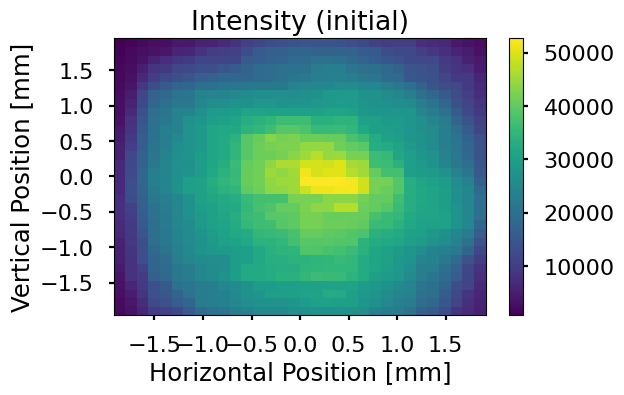

In [4]:
# Plot initial wavefront

intensity_exp_init = srwlib.array('f', [0]*wfr_exp_init.mesh.nx*wfr_exp_init.mesh.ny) # "flat" array to take 2D intensity data
srwl.CalcIntFromElecField(intensity_exp_init, wfr_exp_init, 6, 0, 3, wfr_exp_init.mesh.eStart, 0, 0) # extracts intensity

# Reshaping data from flat to 2D array
intensity_2D_exp_init = np.array(intensity_exp_init).reshape((wfr_exp_init.mesh.nx, wfr_exp_init.mesh.ny), order='C').astype(np.float64)

with plt.style.context(('seaborn-poster')):
    fig = plt.figure(figsize=(6,3.6))
    ax = fig.gca()
    plt.pcolormesh(y_exp_init*(1e3), x_exp_init*(1e3), intensity_2D_exp_init, cmap=plt.cm.viridis, shading='auto')
    plt.colorbar()
    ax.set_ylabel(r'Vertical Position [mm]')
    ax.set_xlabel(r'Horizontal Position [mm]')
    ax.set_title('Intensity (initial)')

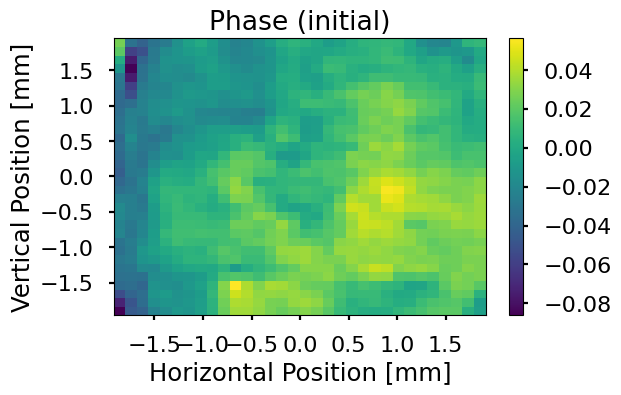

In [5]:
# initial phase
phase_exp_init = srwlib.array('d', [0]*wfr_exp_init.mesh.nx*wfr_exp_init.mesh.ny) # "flat" array to take 2D data
srwl.CalcIntFromElecField(phase_exp_init, wfr_exp_init, 0, 4, 3, wfr_exp_init.mesh.eStart, 0, 0) #extracts the phase; must use double precision

##Reshaping electric field data from flat to 2D array
phase_2d_exp_init = np.array(phase_exp_init).reshape((wfr_exp_init.mesh.nx, wfr_exp_init.mesh.ny), order='C').astype(np.float64)

with plt.style.context(('seaborn-poster')):
    fig = plt.figure(figsize=(6,3.6))
    ax = fig.gca()
    plt.pcolormesh(y_exp_init*(1e3), x_exp_init*(1e3), phase_2d_exp_init, cmap=plt.cm.viridis, shading='auto')
    plt.colorbar()
    ax.set_xlabel(r'Horizontal Position [mm]')
    ax.set_ylabel(r'Vertical Position [mm]')
    ax.set_title('Phase (initial)')

________
Create pulse

In [6]:
# create a laser pulse, using the wavefront created above

_LASER_PULSE = PKDict(
        nslice       = 1,
        chirp        = 0,
        photon_e_ev  = wfr_exp_init.mesh.eStart,
        num_sig_long = 3.,
        #dist_waist   = 0, #.002,
        tau_fwhm     = 0.1 / const.c / math.sqrt(2.),
        pulseE       = 0.001,
        sigx_waist   = 0.000186, # 1.0e-3,
        sigy_waist   = 0.000186, # 1.0e-3,
)

# instantiate the laser pulse (this can take a few seconds)
in_pulse = PKDict(
    **_LASER_PULSE
    )

_______
Initialize crystal

In [7]:
# _N_SLICE_DEFAULT = 50
# _N0_DEFAULT = 1.75
# _N2_DEFAULT = 0.001
# _CRYSTAL_DEFAULTS = PKDict(
#     n0=[_N0_DEFAULT for _ in range(_N_SLICE_DEFAULT)],
#     n2=[_N2_DEFAULT for _ in range(_N_SLICE_DEFAULT)],
#     length=0.2,
#     l_scale=1,
#     nslice=_N_SLICE_DEFAULT,
#     slice_index=0,
#     A = 9.99988571e-01,
#     B = 1.99999238e-01,
#     C = -1.14285279e-04,
#     D = 9.99988571e-01,
#     inversion_n_cells = 64,
#     inversion_mesh_extent = 0.01, # [m]
#     crystal_alpha   = 120.0,      # [1/m], 1.2 1/cm
#     pump_waist      = 0.00164,  # [m]
#     pump_wavelength = 532.0e-9, # [m]
#     pump_energy     = 0.0211,   # [J], pump laser energy onto the crystal
# )

num_slices = 1 #5

crystal_params = PKDict(
        length      = 0.025, # [m]
        nslice      = num_slices,
        l_scale     = 0.08, #abcd_lct value #0.004, 
        n0          = [1.00 for _ in range(num_slices)], #[1.76 for _ in range(num_slices)],
        n2          = [0.00 for _ in range(num_slices)], #[16.0 for _ in range(num_slices)],
        pump_energy = 0.035,    # [J]
        #pump_waist  = (0.0012)/2.355,  # [m]
)

_________
Propagate through crystal once

In [8]:
LP = pulse.LaserPulse(in_pulse)
nslices_pulse = len(LP.slice)

slice=LP.slice
slice[0].wfr = wfr_exp_init
slice[0].n_photons_2d = slice[0].calc_init_n_photons() # Need to recalculate number of photons when updating the wavefront
n_photons_before = np.copy(slice[0].n_photons_2d)

e_crystal = crystal.Crystal(crystal_params)
nslices_crystal = len(e_crystal.slice)

print('\nPropagating ', nslices_pulse, 'laser slices through ', nslices_crystal,' crystal slices')
prop_type = 'gain_calc' #'abcd_lct' #'n0n2_lct' #'n0n2_srw' #'gain_calc'
LP = e_crystal.propagate(LP, prop_type, 1)

wfr_sim_final=LP.slice[0].wfr

x_sim_final=np.linspace(wfr_sim_final.mesh.xStart,wfr_sim_final.mesh.xFin,wfr_sim_final.mesh.nx)
y_sim_final=np.linspace(wfr_sim_final.mesh.yStart,wfr_sim_final.mesh.yFin,wfr_sim_final.mesh.ny)


Propagating  1 laser slices through  1  crystal slices


______
Plot intensity and phase again

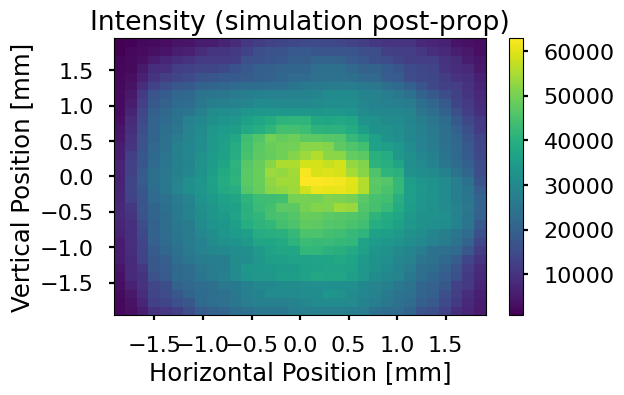

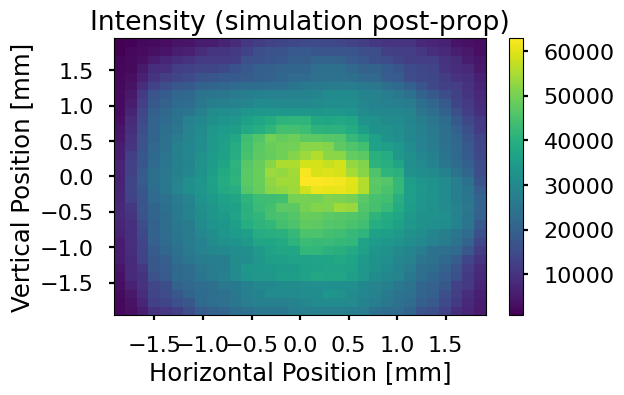

In [9]:
# transmitted pulse - intensity
intensity_sim_final = srwlib.array('f', [0]*wfr_sim_final.mesh.nx*wfr_sim_final.mesh.ny) # "flat" array to take 2D intensity data
srwl.CalcIntFromElecField(intensity_sim_final, wfr_sim_final, 0, 0, 3, wfr_sim_final.mesh.eStart, 0, 0) #extracts intensity

# # Reshaping data from flat to 2D array
intens_2d_sim_final = np.array(intensity_sim_final).reshape((wfr_sim_final.mesh.nx, wfr_sim_final.mesh.ny), order='C').astype(np.float64)
    
with plt.style.context(('seaborn-poster')):
    fig = plt.figure(figsize=(6,3.6))
    ax = fig.gca()
    plt.pcolormesh(y_sim_final*(1e3), x_sim_final*(1e3), intens_2d_sim_final, cmap=plt.cm.viridis, shading='auto') #viridis
    plt.colorbar()
    ax.set_ylabel(r'Vertical Position [mm]')
    ax.set_xlabel(r'Horizontal Position [mm]')
    ax.set_title('Intensity (simulation post-prop)')

x_sim_plot = x_sim_final[np.logical_and(x_sim_final <= x_max_cut,x_sim_final >= x_min_cut)]
y_sim_plot = y_sim_final[np.logical_and(y_sim_final <= y_max_cut,y_sim_final >= y_min_cut)]

intens_2d_sim_final_cut = intens_2d_sim_final[np.logical_and(x_sim_final <= x_max_cut,x_sim_final >= x_min_cut),:]
intens_2d_sim_final_cut = intens_2d_sim_final_cut[:,np.logical_and(y_sim_final <= y_max_cut,y_sim_final >= y_min_cut)]
   
with plt.style.context(('seaborn-poster')):
    fig = plt.figure(figsize=(6,3.6))
    ax = fig.gca()
    plt.pcolormesh(y_sim_plot*(1e3), x_sim_plot*(1e3), intens_2d_sim_final_cut, cmap=plt.cm.viridis, shading='auto') #viridis
    plt.colorbar()
    ax.set_ylabel(r'Vertical Position [mm]')
    ax.set_xlabel(r'Horizontal Position [mm]')
    ax.set_title('Intensity (simulation post-prop)')

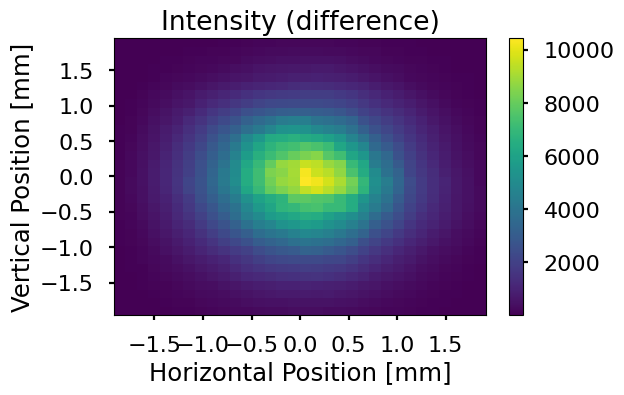

In [10]:
#Plot difference in intensities

diff_intensity_2D_sim = intens_2d_sim_final - intensity_2D_exp_init

with plt.style.context(('seaborn-poster')):
    fig = plt.figure(figsize=(6,3.6))
    ax = fig.gca()
    plt.pcolormesh(y_sim_final*(1e3), x_sim_final*(1e3), diff_intensity_2D_sim, cmap=plt.cm.viridis, shading='auto')
    plt.colorbar()
    ax.set_ylabel(r'Vertical Position [mm]')
    ax.set_xlabel(r'Horizontal Position [mm]')
    ax.set_title('Intensity (difference)')

In [11]:
print(np.max(intens_2d_sim_final)-np.max(intensity_2D_exp_init))

10203.6484375


In [12]:
print(np.sum(np.sum(LP.slice[0].n_photons_2d)) -np.sum(np.sum(n_photons_before)))
print(np.sum(np.sum(n_photons_before)))

25412131.26412046
353723779.50420606


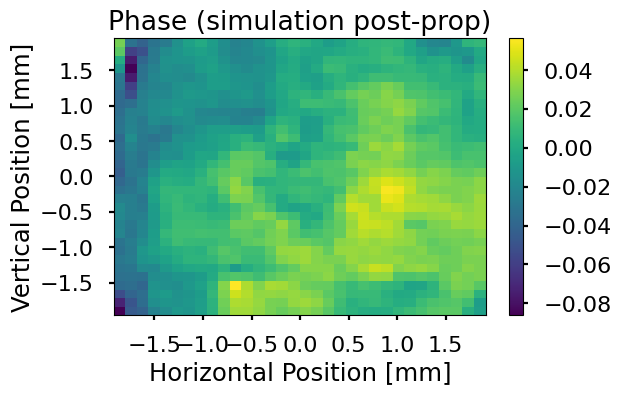

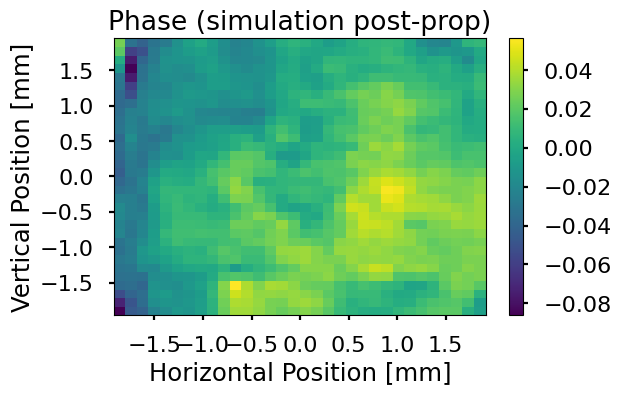

In [13]:
# transmitted pulse - phase
phase_sim_final = srwlib.array('d', [0]*wfr_sim_final.mesh.nx*wfr_sim_final.mesh.ny) # "flat" array to take 2D phase data
srwl.CalcIntFromElecField(phase_sim_final, wfr_sim_final, 0, 4, 3, wfr_sim_final.mesh.eStart, 0, 0) #extracts the phase; must use double precision

# Reshaping data from flat to 2D array
phase_2d_sim_final = np.array(phase_sim_final).reshape((wfr_sim_final.mesh.nx, wfr_sim_final.mesh.ny), order='C').astype(np.float64)

with plt.style.context(('seaborn-poster')):
    fig = plt.figure(figsize=(6,3.6))
    ax = fig.gca()
    plt.pcolormesh(y_sim_final*(1e3), x_sim_final*(1e3), np.unwrap(phase_2d_sim_final), cmap=plt.cm.viridis, shading='auto') #np.unwrap(phase_2d_sim_final)
    plt.colorbar()
    ax.set_ylabel(r'Vertical Position [mm]')#[mm]')
    ax.set_xlabel(r'Horizontal Position [mm]')#[mm]')
    ax.set_title('Phase (simulation post-prop)')

phase_2d_sim_final_cut = phase_2d_sim_final[np.logical_and(x_sim_final <= x_max_cut,x_sim_final >= x_min_cut),:]
phase_2d_sim_final_cut = phase_2d_sim_final_cut[:,np.logical_and(y_sim_final <= y_max_cut,y_sim_final >= y_min_cut)]
   
with plt.style.context(('seaborn-poster')):
    fig = plt.figure(figsize=(6,3.6))
    ax = fig.gca()
    plt.pcolormesh(y_sim_plot*(1e3), x_sim_plot*(1e3), np.unwrap(phase_2d_sim_final_cut), cmap=plt.cm.viridis, shading='auto') #viridis
    plt.colorbar()
    ax.set_ylabel(r'Vertical Position [mm]')
    ax.set_xlabel(r'Horizontal Position [mm]')
    ax.set_title('Phase (simulation post-prop)')


________
Plots from ccd/wfs peak timing data

In [14]:
wfr_exp_final = extract_data('wfs_peak_timing.txt', 'ccd_peak_timing.txt') # Currently no gaussian filter... uncomment if you want

x_exp_final=np.linspace(wfr_exp_final.mesh.xStart,wfr_exp_final.mesh.xFin,wfr_exp_final.mesh.nx)
y_exp_final=np.linspace(wfr_exp_final.mesh.yStart,wfr_exp_final.mesh.yFin,wfr_exp_final.mesh.ny)

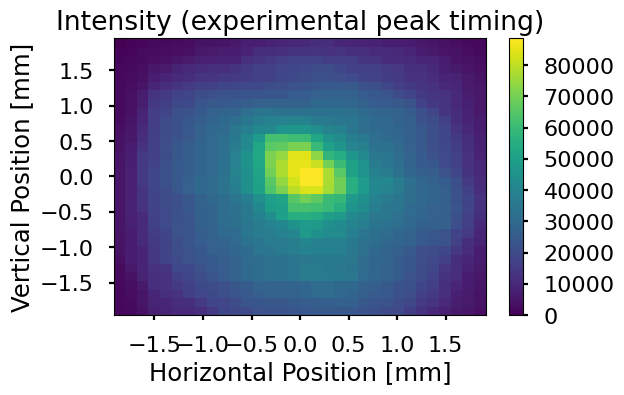

In [15]:
# Extract intensity from experimental post-prop wavefront
intensity_exp_final = srwlib.array('f', [0]*wfr_exp_final.mesh.nx*wfr_exp_final.mesh.ny) # "flat" array to take 2D data
srwl.CalcIntFromElecField(intensity_exp_final, wfr_exp_final, 6, 0, 3, wfr_exp_final.mesh.eStart, 0, 0) #extracts intensity

##Reshaping electric field data from flat to 2D array
intensity_2D_exp_final = np.array(intensity_exp_final).reshape((wfr_exp_final.mesh.nx, wfr_exp_final.mesh.ny), order='C').astype(np.float64)

with plt.style.context(('seaborn-poster')):
    fig = plt.figure(figsize=(6,3.6))
    ax = fig.gca()
    plt.pcolormesh(y_exp_final*(1e3), x_exp_final*(1e3), intensity_2D_exp_final, cmap=plt.cm.viridis, shading='auto')
    plt.colorbar()
    ax.set_ylabel(r'Vertical Position [mm]')
    ax.set_xlabel(r'Horizontal Position [mm]')
    ax.set_title('Intensity (experimental peak timing)')

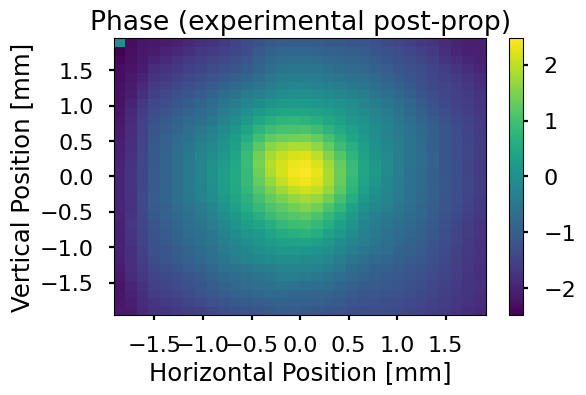

In [16]:
# Extract phase from experimental post-prop wavefront
phase_exp_final = srwlib.array('d', [0]*wfr_exp_final.mesh.nx*wfr_exp_final.mesh.ny) # "flat" array to take 2D data
srwl.CalcIntFromElecField(phase_exp_final, wfr_exp_final, 0, 4, 3, wfr_exp_final.mesh.eStart, 0, 0) #extracts the phase; must use double precision

# Reshaping phase data from flat to 2D array
phase_2d_exp_final = np.array(phase_exp_final).reshape((wfr_exp_final.mesh.nx, wfr_exp_final.mesh.ny), order='C').astype(np.float64)

with plt.style.context(('seaborn-poster')):
    fig = plt.figure(figsize=(6,3.6))
    ax = fig.gca()
    plt.pcolormesh(y_exp_final*(1e3), x_exp_final*(1e3), phase_2d_exp_final, cmap=plt.cm.viridis, shading='auto')
    plt.colorbar()
    ax.set_xlabel(r'Horizontal Position [mm]')
    ax.set_ylabel(r'Vertical Position [mm]')
    ax.set_title('Phase (experimental post-prop)')

________
With gain on, n1 = 1, n2 = 0, should see gain in peak intensity (gain) that matches the difference between two maximum intensities for peak and off peak timing

In [17]:
# _op = _off_peak
wfr_exp_final_op = extract_data('wfs_off_peak_timing.txt', 'ccd_off_peak_timing.txt') # Currently no gaussian filter... uncomment if you want

x_exp_final_op=np.linspace(wfr_exp_final_op.mesh.xStart,wfr_exp_final_op.mesh.xFin,wfr_exp_final_op.mesh.nx)
y_exp_final_op=np.linspace(wfr_exp_final_op.mesh.yStart,wfr_exp_final_op.mesh.yFin,wfr_exp_final_op.mesh.ny)

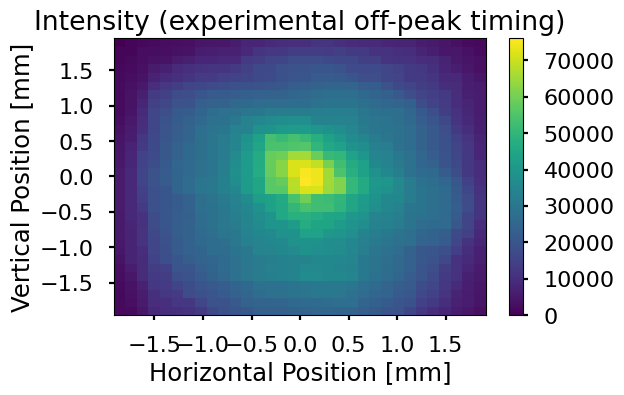

In [18]:
# Plot off-peak timing intensity

# Extract intensity from experimental post-prop wavefront
intensity_exp_final_op = srwlib.array('f', [0]*wfr_exp_final_op.mesh.nx*wfr_exp_final_op.mesh.ny) # "flat" array to take 2D data
srwl.CalcIntFromElecField(intensity_exp_final_op, wfr_exp_final_op, 6, 0, 3, wfr_exp_final_op.mesh.eStart, 0, 0) #extracts intensity

##Reshaping electric field data from flat to 2D array
intensity_2D_exp_final_op = np.array(intensity_exp_final_op).reshape((wfr_exp_final_op.mesh.nx, wfr_exp_final_op.mesh.ny), order='C').astype(np.float64)

with plt.style.context(('seaborn-poster')):
    fig = plt.figure(figsize=(6,3.6))
    ax = fig.gca()
    plt.pcolormesh(y_exp_final_op*(1e3), x_exp_final_op*(1e3), intensity_2D_exp_final_op, cmap=plt.cm.viridis, shading='auto')
    plt.colorbar()
    ax.set_ylabel(r'Vertical Position [mm]')
    ax.set_xlabel(r'Horizontal Position [mm]')
    ax.set_title('Intensity (experimental off-peak timing)')

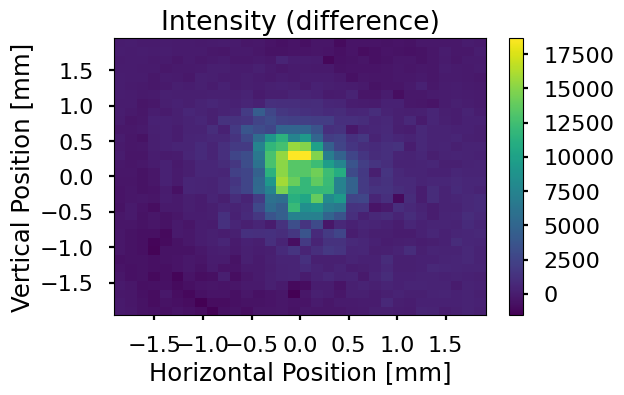

In [19]:
# Plot difference in intensities

diff_intensity_2D_exp_final = intensity_2D_exp_final - intensity_2D_exp_final_op

with plt.style.context(('seaborn-poster')):
    fig = plt.figure(figsize=(6,3.6))
    ax = fig.gca()
    plt.pcolormesh(y_exp_final*(1e3), x_exp_final*(1e3), diff_intensity_2D_exp_final, cmap=plt.cm.viridis, shading='auto')
    plt.colorbar()
    ax.set_ylabel(r'Vertical Position [mm]')
    ax.set_xlabel(r'Horizontal Position [mm]')
    ax.set_title('Intensity (difference)')

In [20]:
print(np.max(intensity_2D_exp_final) - np.max(intensity_2D_exp_final_op))

12512.0078125


In [21]:
LP_peak = pulse.LaserPulse(in_pulse)
LP_peak.slice[0].wfr = wfr_exp_init

LP_off_peak = pulse.LaserPulse(in_pulse)
LP_off_peak.slice[0].wfr = wfr_exp_final_op

print(np.sum(np.sum(LP_peak.slice[0].calc_init_n_photons())) -np.sum(np.sum(LP_off_peak.slice[0].calc_init_n_photons())))

18252992.80948317
